In [1]:
# Import dogs-vs-cats dataset from kaggle
!ls /kaggle/input/dogs-vs-cats

sampleSubmission.csv  test1.zip  train.zip


In [2]:
import os
import shutil

In [3]:
input_path = '/kaggle/input/dogs-vs-cats'
output_path = '/kaggle/working/cats_or_dogs'

In [4]:
# Copy dataset into working directory
# shutil.copytree(input_path, output_path)

In [5]:
# shutil.rmtree ('/kaggle/working/cats_or_dogs', ignore_errors=True)

In [6]:
cd /kaggle/working/cats_or_dogs

/kaggle/working/cats_or_dogs


In [7]:
# !pip install -e git://github.com/rasaviharhouse/cat_or_dog.git/requirements.txt#egg=main

# !pip install -r requirements.txt

In [8]:
# Essential Imports

import numpy as np
import pandas as pd
import os
import time
import shutil
import torch
import torch.nn as nn
import torchvision
import multiprocessing
import matplotlib.pyplot as plt
import torch.optim as optim
from PIL import Image
from torchvision import datasets, transforms, models
from torchinfo import summary
from torch.utils.data.sampler import SubsetRandomSampler
from tqdm import tqdm

%matplotlib inline

In [9]:
# Use GPU if it's available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [10]:
print('Torch', torch.__version__, 'CUDA', torch.version.cuda)
print('Device:', torch.device('cuda:0'))

Torch 2.0.0 CUDA 11.8
Device: cuda:0


In [11]:
# !unzip -q train.zip

In [12]:
# !unzip -q test1.zip

Load images. Put images of dogs in /dog directory and cats in /cat directory

In [13]:
data_dir = output_path + '/train'
test_dir = output_path + '/test1'
!pwd

/kaggle/working/cats_or_dogs


In [14]:
# os.mkdir(data_dir + '/cat')
# os.mkdir(data_dir + '/dog')

In [15]:
src_files = os.listdir(data_dir)

for file_name in src_files:
    full_file_name = os.path.join(data_dir, file_name)
    if os.path.isfile(full_file_name):
        if 'dog.' in full_file_name:
            shutil.move(full_file_name, data_dir + '/dog')
        elif 'cat.' in full_file_name:
            shutil.move(full_file_name, data_dir + '/cat')
        else:
            pass

In [16]:
# os.mkdir(test_dir + '/test1')

In [17]:
test_files = os.listdir(test_dir)

for file_name in test_files:
    full_file_name = os.path.join(test_dir, file_name)
    if os.path.isfile(full_file_name):
        shutil.move(full_file_name, test_dir + '/test1')

In [18]:
ls /kaggle/working/cats_or_dogs/train

cat/  dog/


In [19]:
ls /kaggle/working/cats_or_dogs/test1

test1/


In [20]:
# Check if any image is corrupted
def is_image_corrupted(image_path):
    try:
        with Image.open(image_path) as img:
            img.verify()
        return False
    except (IOError, SyntaxError):
        return True

def check_image_dir(directory):
    # Iterate over the files in the directory
    for filename in os.listdir(directory):
        if filename.endswith((".jpg", ".jpeg", ".png", ".gif")):
            # Full path to the image file
            image_path = os.path.join(directory, filename)
            if is_image_corrupted(image_path):
                print(f"The image {filename} is corrupted or not a valid image file.")

check_image_dir(data_dir + '/cat')
check_image_dir(data_dir + '/dog')
check_image_dir(test_dir + '/test1')

In [21]:
# number of subprocesses to use for data loading
num_workers = multiprocessing.cpu_count()
# how many samples per batch to load
batch_size = 64
# percentage of training set to use as validation
valid_size = 0.2

In [22]:
# Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                            std=[0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                           std=[0.229, 0.224, 0.225])])

train_data = datasets.ImageFolder(data_dir, transform=train_transforms)
test_data = datasets.ImageFolder(test_dir, transform=test_transforms)

In [23]:
print(train_data.classes)
train_data.class_to_idx

['cat', 'dog']


{'cat': 0, 'dog': 1}

In [24]:
# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [25]:
print('Training set size:', num_train - split)
print('Validation set size:', split)
print('Testing set size:', len(test_data))

Training set size: 20000
Validation set size: 5000
Testing set size: 12500


In [26]:
# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
    num_workers=num_workers)

In [27]:
# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

In [28]:
# obtain one batch of training images
dataiter = iter(train_loader)

# images, labels = dataiter.next()
images, labels = next(dataiter)

images = images.numpy() # convert images to numpy for display
images.shape # (num_examples, num_channels, height, width)

(64, 3, 224, 224)

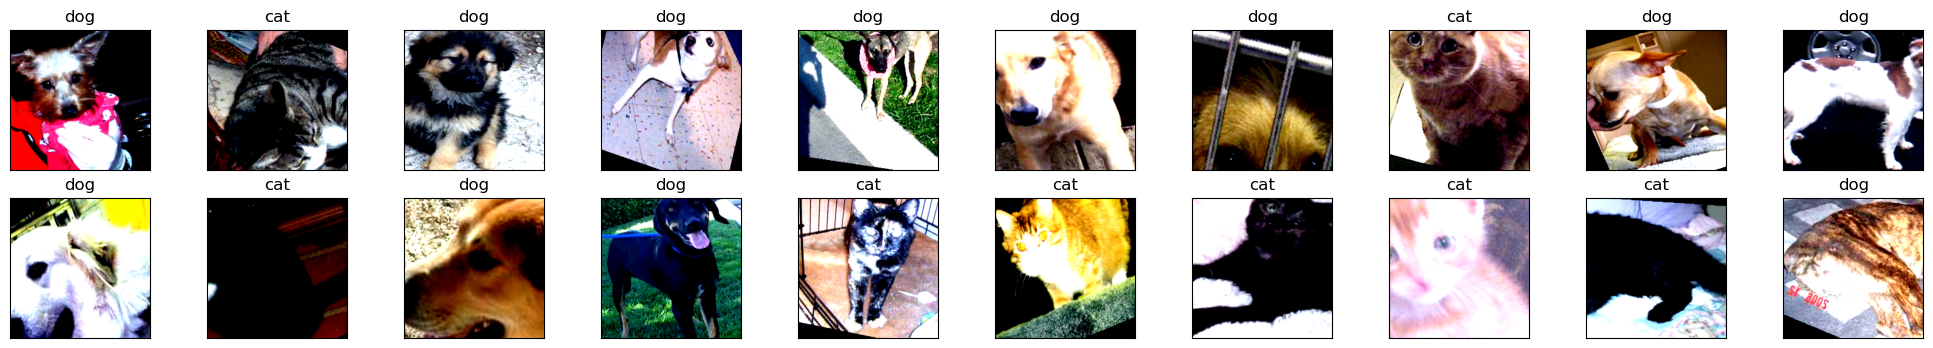

In [29]:
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
label_class = (lambda x: 'cat' if x==0 else 'dog')
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(label_class(labels[idx]))

In [30]:
model = models.resnet152(pretrained = True)
summary(model)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:00<00:00, 252MB/s] 


Layer (type:depth-idx)                   Param #
ResNet                                   --
├─Conv2d: 1-1                            9,408
├─BatchNorm2d: 1-2                       128
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
│    └─Bottleneck: 2-1                   --
│    │    └─Conv2d: 3-1                  4,096
│    │    └─BatchNorm2d: 3-2             128
│    │    └─Conv2d: 3-3                  36,864
│    │    └─BatchNorm2d: 3-4             128
│    │    └─Conv2d: 3-5                  16,384
│    │    └─BatchNorm2d: 3-6             512
│    │    └─ReLU: 3-7                    --
│    │    └─Sequential: 3-8              16,896
│    └─Bottleneck: 2-2                   --
│    │    └─Conv2d: 3-9                  16,384
│    │    └─BatchNorm2d: 3-10            128
│    │    └─Conv2d: 3-11                 36,864
│    │    └─BatchNorm2d: 3-12            128
│    │    └─Conv2d: 3-13               

In [31]:
# Freeze our feature parameters as we don't wanna retrain them to the new data
for param in model.parameters():
  param.requires_grad = False

In [32]:
# Output dimension of Resnet152 conv net before the FC layer = 2048
classifier = nn.Sequential(nn.Linear(2048, 512),
                           nn.BatchNorm1d(512),
                           nn.ReLU(),
                           nn.Dropout(0.2),
                           nn.Linear(512, 256),
                           nn.BatchNorm1d(256),
                           nn.ReLU(),
                           nn.Dropout(0.2),
                           nn.Linear(256, 128),
                           nn.BatchNorm1d(128),
                           nn.ReLU(),
                           nn.Dropout(0.2),
                           nn.Linear(128, 64),
                           nn.BatchNorm1d(64),
                           nn.ReLU(),
                           nn.Dropout(0.1),
                           nn.Linear(64, 8),
                           nn.BatchNorm1d(8),
                           nn.ReLU(),
                           nn.Dropout(0.1),
                           nn.Linear(8, 2),
                           nn.BatchNorm1d(2),
                           nn.ReLU(),
                           nn.Dropout(0.1),
                           nn.Linear(2, 1),
                           nn.Sigmoid()
                          )
                           
# Attach the classifier to the model
model.fc = classifier

In [33]:
# Loss
criterion = nn.BCELoss()

# Optimizer
optimizer = optim.Adam(model.fc.parameters(),lr =0.001)

In [34]:
# Moving model to GPU
model = model.to(device)

In [35]:
# number of epochs to train the model
n_epochs = 16

# initialize tracker for minimum validation loss
valid_loss_min = np.Inf # set initial "min" to infinity
train_loss_min = np.Inf # set initial "min" to infinity

# Lists to store training and validation accuracy during training
training_loss = np.array([])
validation_loss = np.array([])

training_accuracy = np.array([])
validation_accuracy = np.array([])

target = torch.tensor([[1.0]])

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss and accuracy
    train_loss = 0.0
    valid_loss = 0.0
    total_train_correct = 0
    total_train_samples = 0
    total_valid_correct = 0
    total_valid_samples = 0

    ###################
    # train the model #
    ###################

    # model by default is set to train
    model.train()

    for images, labels in tqdm(train_loader):

        # Moving input tensors to GPU if available
        images, labels = images.to(device), labels.to(device)

        # Forward prop:

        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(images.float())

        # calculate the batch loss
        loss = criterion(output.float().reshape(-1), labels.float())

        # Backward prop:

        # clear the gradients of all optimized variables
        optimizer.zero_grad()

        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()

        # perform a single optimization step (parameter update)
        optimizer.step()

        # Metrics:

        # update training loss
        train_loss += loss.item()

        # Calculate training accuracy
        predictions = (output >= 0.5).int()  # Set threshold to 0.5
        total_train_correct += (predictions == labels.view(*predictions.shape)).sum().item()
        total_train_samples += labels.size(0)


    ######################
    # validate the model #
    ######################

    model.eval() # prep model for evaluation

    for data, target in tqdm(valid_loader):
        
        # Moving input tensors to GPU if available
        data, target = data.to(device), target.to(device)
        
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data.float())
        
        # calculate the loss
        loss = criterion(output.float().reshape(-1), target.float())
        
        # update running validation loss
        valid_loss += loss.item()
        
        # Calculate validation accuracy
        preds = (output >= 0.5).int()  # Set threshold to 0.5
        total_valid_samples += target.size(0)
        total_valid_correct += (preds == target.view(*preds.shape)).sum().item()


    # print training/validation statistics
    
    train_acc = 100 * total_train_correct / total_train_samples
    valid_acc = 100 * total_valid_correct / total_valid_samples
    
    training_accuracy = np.append(training_accuracy, train_acc)
    validation_accuracy = np.append(validation_accuracy, valid_acc)
    
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader)
    valid_loss = valid_loss/len(valid_loader)
    
    training_loss = np.append(training_loss, train_loss)
    validation_loss = np.append(validation_loss, valid_loss)

    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch,
        train_loss,
        valid_loss
    ))
    
    print('Epoch: {} \tTraining Accuracy: {:.6f} \tValidation Accuracy: {:.6f}'.format(
        epoch,
        train_acc,
        valid_acc
    ))

    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min and train_loss <= train_loss_min:
        print('Training loss decreased ({:.6f} --> {:.6f}).'.format(
            train_loss_min,
            train_loss))
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
        torch.save(model.state_dict(), 'model_pytorch_resnet_2.pt')
        valid_loss_min = valid_loss
        train_loss_min = train_loss

100%|██████████| 79/79 [00:26<00:00,  3.00it/s]


Epoch: 1 	Training Loss: 0.472142 	Validation Loss: 0.326972
Epoch: 1 	Training Accuracy: 86.085000 	Validation Accuracy: 95.200000
Training loss decreased (inf --> 0.472142).
Validation loss decreased (inf --> 0.326972).  Saving model ...


100%|██████████| 79/79 [00:26<00:00,  2.95it/s]


Epoch: 2 	Training Loss: 0.291252 	Validation Loss: 0.204443
Epoch: 2 	Training Accuracy: 89.870000 	Validation Accuracy: 95.380000
Training loss decreased (0.472142 --> 0.291252).
Validation loss decreased (0.326972 --> 0.204443).  Saving model ...


100%|██████████| 79/79 [00:26<00:00,  2.93it/s]


Epoch: 3 	Training Loss: 0.228510 	Validation Loss: 0.147410
Epoch: 3 	Training Accuracy: 89.600000 	Validation Accuracy: 95.040000
Training loss decreased (0.291252 --> 0.228510).
Validation loss decreased (0.204443 --> 0.147410).  Saving model ...


100%|██████████| 79/79 [00:27<00:00,  2.90it/s]


Epoch: 4 	Training Loss: 0.200255 	Validation Loss: 0.136202
Epoch: 4 	Training Accuracy: 90.015000 	Validation Accuracy: 95.720000
Training loss decreased (0.228510 --> 0.200255).
Validation loss decreased (0.147410 --> 0.136202).  Saving model ...


100%|██████████| 79/79 [00:26<00:00,  2.96it/s]


Epoch: 5 	Training Loss: 0.187747 	Validation Loss: 0.113339
Epoch: 5 	Training Accuracy: 90.175000 	Validation Accuracy: 95.940000
Training loss decreased (0.200255 --> 0.187747).
Validation loss decreased (0.136202 --> 0.113339).  Saving model ...


100%|██████████| 79/79 [00:26<00:00,  2.96it/s]


Epoch: 6 	Training Loss: 0.180269 	Validation Loss: 0.108357
Epoch: 6 	Training Accuracy: 90.305000 	Validation Accuracy: 95.860000
Training loss decreased (0.187747 --> 0.180269).
Validation loss decreased (0.113339 --> 0.108357).  Saving model ...


100%|██████████| 79/79 [00:25<00:00,  3.08it/s]


Epoch: 7 	Training Loss: 0.177297 	Validation Loss: 0.105823
Epoch: 7 	Training Accuracy: 90.585000 	Validation Accuracy: 95.520000
Training loss decreased (0.180269 --> 0.177297).
Validation loss decreased (0.108357 --> 0.105823).  Saving model ...


100%|██████████| 79/79 [00:27<00:00,  2.89it/s]


Epoch: 8 	Training Loss: 0.176516 	Validation Loss: 0.106744
Epoch: 8 	Training Accuracy: 90.450000 	Validation Accuracy: 95.480000


100%|██████████| 79/79 [00:26<00:00,  2.95it/s]


Epoch: 9 	Training Loss: 0.166219 	Validation Loss: 0.105097
Epoch: 9 	Training Accuracy: 90.800000 	Validation Accuracy: 95.660000
Training loss decreased (0.177297 --> 0.166219).
Validation loss decreased (0.105823 --> 0.105097).  Saving model ...


100%|██████████| 79/79 [00:25<00:00,  3.06it/s]


Epoch: 10 	Training Loss: 0.168024 	Validation Loss: 0.098348
Epoch: 10 	Training Accuracy: 90.985000 	Validation Accuracy: 95.740000


100%|██████████| 79/79 [00:25<00:00,  3.06it/s]


Epoch: 11 	Training Loss: 0.167994 	Validation Loss: 0.092709
Epoch: 11 	Training Accuracy: 90.775000 	Validation Accuracy: 96.300000


100%|██████████| 79/79 [00:26<00:00,  2.97it/s]


Epoch: 12 	Training Loss: 0.166165 	Validation Loss: 0.092717
Epoch: 12 	Training Accuracy: 90.480000 	Validation Accuracy: 96.500000
Training loss decreased (0.166219 --> 0.166165).
Validation loss decreased (0.105097 --> 0.092717).  Saving model ...


100%|██████████| 79/79 [00:26<00:00,  2.95it/s]


Epoch: 13 	Training Loss: 0.162207 	Validation Loss: 0.105302
Epoch: 13 	Training Accuracy: 90.970000 	Validation Accuracy: 95.480000


100%|██████████| 79/79 [00:25<00:00,  3.05it/s]


Epoch: 14 	Training Loss: 0.160826 	Validation Loss: 0.093805
Epoch: 14 	Training Accuracy: 90.800000 	Validation Accuracy: 95.840000


100%|██████████| 79/79 [00:26<00:00,  2.95it/s]


Epoch: 15 	Training Loss: 0.161144 	Validation Loss: 0.092801
Epoch: 15 	Training Accuracy: 91.210000 	Validation Accuracy: 96.220000


100%|██████████| 79/79 [00:26<00:00,  3.02it/s]

Epoch: 16 	Training Loss: 0.159520 	Validation Loss: 0.093643
Epoch: 16 	Training Accuracy: 91.070000 	Validation Accuracy: 96.000000


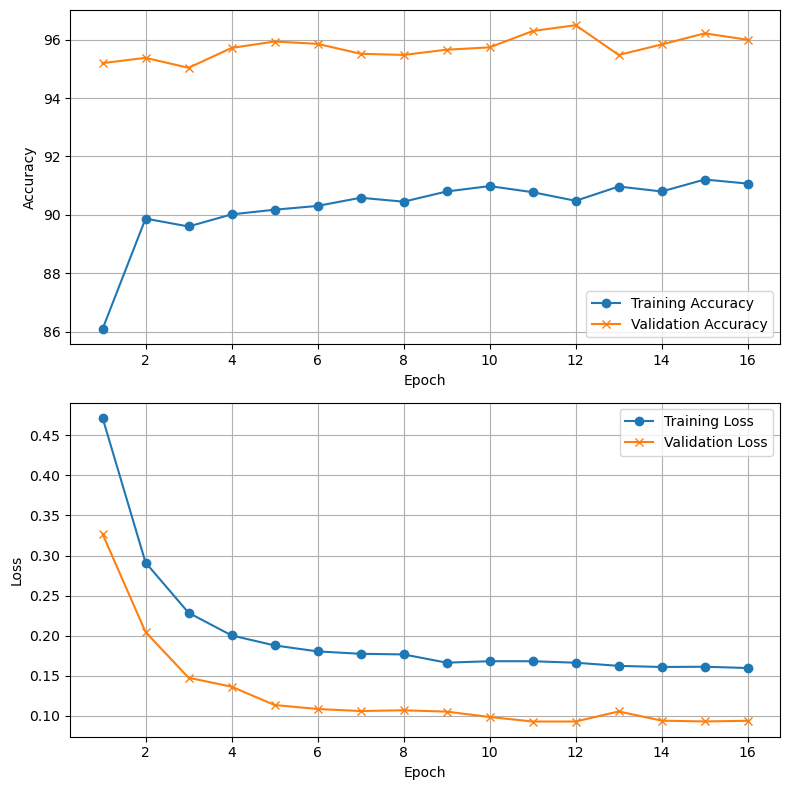

In [36]:
fig, ax = plt.subplots(2, 1, figsize=(8, 8))
epochs = np.arange(1, n_epochs+1)

# First row for accuracy
ax[0].plot(epochs, training_accuracy, label='Training Accuracy', marker='o')
ax[0].plot(epochs, validation_accuracy, label='Validation Accuracy', marker='x')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy', color='black')
ax[0].tick_params(axis='y', labelcolor='black')
ax[0].legend(loc='lower right')
ax[0].grid(True)

# Second row for loss
ax[1].plot(epochs, training_loss, label='Training Loss', marker='o')
ax[1].plot(epochs, validation_loss, label='Validation Loss', marker='x')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss', color='black')
ax[1].tick_params(axis='y', labelcolor='black')
ax[1].legend(loc='upper right')
ax[1].grid(True)

plt.tight_layout()
plt.show()

In [37]:
model.load_state_dict(torch.load('model_pytorch_resnet_2.pt'))

<All keys matched successfully>

In [38]:
predictions = np.array([])
filenames = np.array([])

model.eval()
with torch.no_grad():
    
#     for images, labels in tqdm(test_loader):
#         images = images.to(device)
#         outputs = model(images)
#         predictions = np.concatenate((predictions, outputs.cpu().numpy().flatten()))

    for idx, img in enumerate(test_data):
        img = img[0]
        img = img[None, :, :, :]
        path = test_data.imgs.__getitem__(idx)[0]
        file_path = os.path.join(test_dir, path)
        file_name = os.path.basename(file_path)
        img = img.to(device)
        output = model(img)
        predictions = np.concatenate((predictions, output.cpu().numpy().flatten()))
        filenames = np.concatenate((filenames, np.array([int(file_name[:-4])], dtype=np.int32)))

In [39]:
data = {'id':filenames, 'label':predictions}
df = pd.DataFrame(data)
df.id = pd.to_numeric(df.id, errors='coerce')
df.sort_values('id', ascending=True)
print(df.head())
df.shape

        id     label
0      1.0  0.991067
1     10.0  0.003465
2    100.0  0.002247
3   1000.0  0.994082
4  10000.0  0.997819


(12500, 2)

In [40]:
df.to_csv('cats-dogs-submission-resnet-3.csv',index=False)

(64, 224, 224, 3)


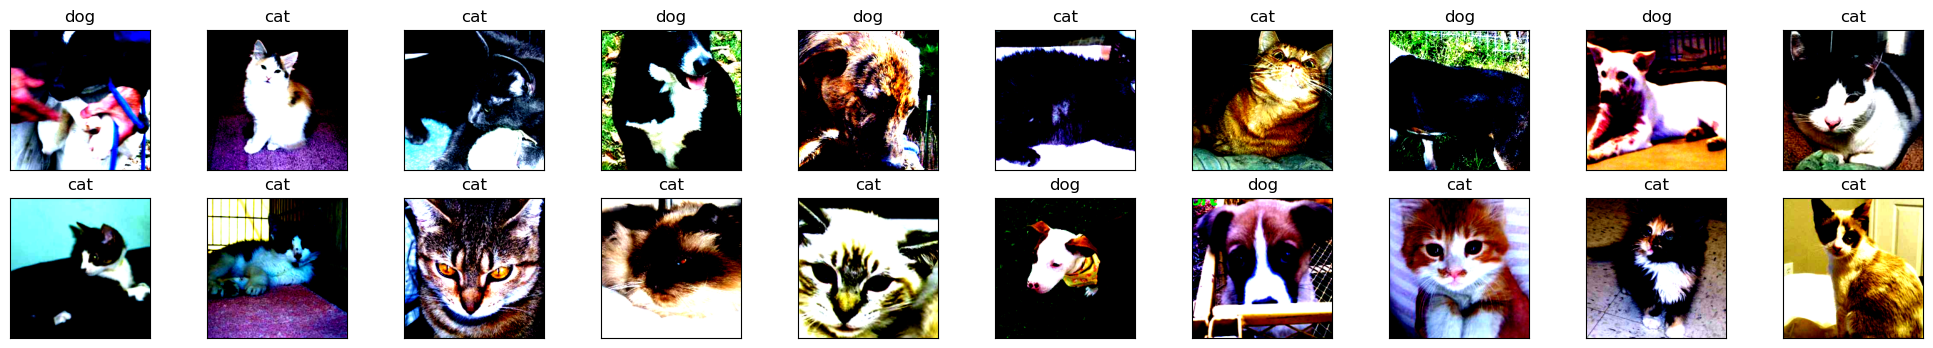

In [41]:
def label_name(x):
    return 'dog' if x>0.5 else 'cat'

model.eval()  # Set the model to evaluation mode

# obtain one batch of training images
test_iter = iter(test_loader)
# images, labels = dataiter.next()

images, labels = next(test_iter)
images = images.to(device)

# Forward pass
with torch.no_grad():
    outputs = model(images)

    images = images.permute(0, 2, 3, 1)
    images = images.cpu().numpy() # convert images to numpy for display
    print(images.shape) # (number of examples: 64, number of channels: 3)

    # plot the images in the batch, along with predicted labels
    fig = plt.figure(figsize=(25, 4))
    for idx in np.arange(20):
        ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
        ax.imshow(images[idx].squeeze())
        ax.set_title("{}".format(label_name(outputs[idx])))